# CSCE 633 :: Machine Learning :: Texas A&M University :: Fall 2023

# Project

**Name: Shashank Santosh Jagtap**           
**UIN:534002338**  

## Problem Statement:

- We are given a Yelp review dataset, which comprises around 174000 reviews with stars. We will be using only a subset of this dataset for experiments. Our goal is to implement the powerful Transformer model for sentiment analysis based on the text review and stars.


#### Imported all necessary libraries

In [51]:
import pandas as pd
from collections import defaultdict
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

import torch
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import SGD

from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup, BertConfig

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


import matplotlib.pyplot as plt

# (a) Data Pre-processing

#### Imported training and testing datasets.

In [2]:
train_df = pd.read_csv('yelp_review_train.csv')

test_df = pd.read_csv('yelp_review_test.csv')

In [3]:
train_df.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


#### Performed 3 pre-processing steps 
1. Conversion to lowercase
2. Removing punctuations
3. Removing stopwords

These steps help the model to learn faster without learning unnecessary words

In [4]:
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word.isalnum() and word not in stop_words]

    # Join the words back into a single string
    text = ' '.join(words)

    return text

# Apply text pre-processing to the 'text' column
train_df['text'] = train_df['text'].apply(preprocess_text)


In [5]:
train_df.head()

,text,stars
0,went lunch found burger meh obvious focus burg...,2.0
1,needed new tires wifes car special order next ...,5.0
2,jim woltman works goleta honda 5 stars knowled...,5.0
3,times get shrimp theyve got nice selection dif...,4.0
4,one fantastic place eat whether hungry need go...,5.0


#### Conversion of stars to 3 levels and building a new column named 'sentiment'

In [6]:
# Convert stars into three levels
train_df['sentiment'] = train_df['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))
train_df.head()

,text,stars,sentiment
0,went lunch found burger meh obvious focus burg...,2.0,Negative
1,needed new tires wifes car special order next ...,5.0,Positive
2,jim woltman works goleta honda 5 stars knowled...,5.0,Positive
3,times get shrimp theyve got nice selection dif...,4.0,Positive
4,one fantastic place eat whether hungry need go...,5.0,Positive


# (b) Input Data Preparation

#### Any transformer model needs the input in a specific format. In this section we will achieve this by performing 3 steps on the data.

1. Build Vocabulary: This creates a vocabulary of the words used throughout the training data. It is similar to the vocabulary seen in a language dictionary.
2. Fixed length sequence: Convert words to integers using vocabulary.
3. Padding of these sequences: Padding is done so that almost all the words are represented in same length. Generally, padding is performed to such a extent for any words so that it matches the length of the maximum word in vocabulary. But in this case we took max_len = 100, because the original maximum length was almost 520 which would have drastically increase the complexity of calculations while training the transformer. Additionally, it would have increased the training time to a greater extent.  

In [7]:
# Assuming train_df['text'] is a list of strings
tokenized_texts = [word_tokenize(text) for text in train_df['text']]

# Create an iterator over tokenized texts
def token_iterator():
    for tokens in tokenized_texts:
        yield tokens

# Build Vocabulary
vocab = build_vocab_from_iterator(token_iterator())

# Convert words to integers using the vocabulary
text_to_int = lambda x: [vocab[token] for token in x]
int_texts = [text_to_int(tokens) for tokens in tokenized_texts]

# Pad Sequences to Fixed Length
max_len = 100  # Choose your desired fixed length
padded_texts = [torch.nn.functional.pad(torch.tensor(seq), pad=(0, max_len - len(seq)), mode='constant', value=0) for seq in int_texts]

# Convert to PyTorch tensor
padded_texts = torch.stack(padded_texts)

# Now, padded_texts can be used as input to the Transformer model


#### Example of how the padded text looks like.

In [8]:
print (padded_texts[0])

tensor([3.6000e+01, 1.0300e+02, 1.5100e+02, 1.6600e+02, 1.7230e+03, 2.1120e+03,
        2.5390e+03, 5.4600e+02, 4.0400e+02, 1.3500e+02, 2.0950e+03, 1.9020e+03,
        3.3730e+03, 1.5900e+02, 1.9100e+02, 1.6600e+02, 2.3450e+03, 3.1900e+02,
        2.0670e+03, 1.8700e+03, 1.4568e+04, 2.3450e+03, 8.5710e+03, 1.2730e+03,
        4.6000e+01, 8.0000e+00, 1.6760e+03, 3.0100e+02, 6.4180e+03, 4.9000e+01,
        1.6600e+02, 5.6470e+03, 2.6600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

#### Created a new column 'sentiment_encoded' as the target variable which is based on 'sentiment' column.

In [9]:
# Mapping dictionary
sentiment_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}

# Apply the mapping to create a new 'sentiment_encoded' column
train_df['sentiment_encoded'] = train_df['sentiment'].map(sentiment_mapping)


In [10]:
train_df.head()

,text,stars,sentiment,sentiment_encoded
0,went lunch found burger meh obvious focus burg...,2.0,Negative,0
1,needed new tires wifes car special order next ...,5.0,Positive,2
2,jim woltman works goleta honda 5 stars knowled...,5.0,Positive,2
3,times get shrimp theyve got nice selection dif...,4.0,Positive,2
4,one fantastic place eat whether hungry need go...,5.0,Positive,2


# (c) Transformer Implementation

##### Setting the PyTorch device to the GPU ("cuda:0") if a GPU is available; otherwise, it sets it to the CPU ("cpu"). I have implemented this project on TAMU's HPRC Grace server. 

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### In this project I will be using BERT pretrained model along with some modifications to its architecture to achieve greater results.
- BERT, or Bidirectional Encoder Representations from Transformers, uses a transformer architecture with a specific configuration. The original BERT model, known as BERTBASE, has the following specifications:

1. Number of Layers: BERTBASE has 12 layers in its transformer architecture.
2. Number of Attention Heads: Each layer has 12 attention heads.
3. Hidden Size: The hidden size of the model (dimension of the internal representation) is 768.
4. Total Parameters: BERTBASE has a total of 110 million parameters.


#### Initialized tokenizer specific to BERT model. 

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

PyTorch dataset class named ReviewDataset for handling text reviews and their corresponding targets in a natural language processing task. The dataset utilizes a tokenizer to encode reviews, ensuring they are formatted with special tokens and fit within a specified maximum length (max_len), and it returns the input IDs, attention mask, and target values for each item. The dataset is designed to be used in PyTorch data loaders, providing a convenient interface for training or evaluating models on tasks such as sentiment analysis.

In [13]:
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [14]:
# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [15]:
train_df.shape

(139805, 4)

In [16]:
val_df.shape

(34952, 4)

Passing 'text' and 'sentiment_encoded' columns to the ReviewDataset to prepare a ds to pass to the BERT model. These operations are similar to the preprocessing steps we did earlier but these are more specific to BERT model. The function returns a PyTorch DataLoader configured with the created dataset, ready to be used for training or evaluating a model in batches with the specified batch size.

In [17]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df['text'].to_numpy(),
        targets = df['sentiment_encoded'].to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [18]:
# Convert stars into three levels
test_df['sentiment'] = test_df['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))

# Mapping dictionary
sentiment_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}

# Apply the mapping to create a new 'sentiment_encoded' column
test_df['sentiment_encoded'] = test_df['sentiment'].map(sentiment_mapping)

test_df.head()

,text,stars,sentiment,sentiment_encoded
0,"Hidden treasure! Awesome service, delicious fo...",5.0,Positive,2
1,My family and I have been patients since I wa...,5.0,Positive,2
2,"I rarely get pedicures, but Blue Nail's practi...",5.0,Positive,2
3,"We came with a large group, may of the items w...",2.0,Negative,0
4,The view is great from Morgan's Pier. The bart...,2.0,Negative,0


The following block of code creates PyTorch data loaders (train_data_loader, val_data_loader, test_data_loader) for the training, validation, and test sets, using the create_data_loader function. Each data loader processes the corresponding DataFrame (train_df, val_df, test_df), employing a tokenizer with a maximum sequence length of 120 and batches of size 32.

In [19]:
BATCH_SIZE = 32
MAX_LEN = 120

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

Initializing BERT pretrained model.

In [20]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)     

SentimentClassifier class describes the architecture which incorporates fine-tuning of a pre-trained BERT model and additional fully connected layers for the specific classification task. Architecture of the fine tuned model is:
1. There are total 9 layers of bert model (we freezed 3 encoder layers to reduce complexity of the model and build it specifically for our dataset and objective).
2. We will pass the input_ids calulated above of our training dataset. Also the attention mask help model to identify which data is padded and which is not to better learn from it. 
3. Following these 9 layers of pretrained BERT model, we have a drouput layer with droupout rate of 40% to overcome overfitting.
4. After dropout layer is a linear layer with all the input parameters of bert and giving out 128 output parameters from it. 
5. Next is the activation layer (ReLU).
6. Similarly, there is one more linear layer with activation and dropout layer.
7. Finally, the code returns 3 output parameters which is the number target classification labels.


In [21]:
class SentimentClassifier(nn.Module):
      def __init__(self, n_classes):
            super(SentimentClassifier, self).__init__()
            self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        
            # Freeze the first 3 layers of BERT
            for i in range(3):
                for param in self.bert.encoder.layer[i].parameters():
                    param.requires_grad = False
                    
            self.drop = nn.Dropout(p=0.4)
            self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
            self.out2 = nn.Linear(128, 64)
            self.relu = nn.ReLU()
            self.out = nn.Linear(64, n_classes)
      
      def forward(self, input_ids, attention_mask):
            _, pooled_output = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask)
            output = self.drop(pooled_output)
            output = self.out1(output)
            output = self.relu(output)
            output = self.drop(output)
            output = self.out2(output)
            output = self.relu(output)
            output = self.drop(output)
            return self.out(output)

Now we save this model in 'model' and set to run on CUDA.

In [ ]:
model = SentimentClassifier(3)
model = model.to(device)

**Note:** We have used BERT pretrained model and hence we were required to preprocess the data using inbuilt functions in BERT library. Therefore, we have not explicitly included the implementation of positional embeddings, a vocabulary embedding table, or mask indicators for padded tokens. However, these aspects are typically handled by the BERT model itself and the tokenizer used. Let me explain how:

1. Positional Embeddings: BERT inherently incorporates positional embeddings. The transformer architecture used by BERT is designed to handle the order of words through the use of positional embeddings. These embeddings are added to the input embeddings to provide information about the position of each token in the sequence.

2. Vocabulary Embedding Table: The BERT model loads a pre-trained vocabulary embedding table when initialized with BertModel.from_pretrained('bert-base-uncased'). The embedding table contains word embeddings for each token in the vocabulary. This pre-trained embedding table is crucial for BERT's ability to understand the meaning of words in context.

3. Mask Indicators for Padded Tokens: The tokenizer used when encoding the input in the ReviewDataset class sets return_attention_mask=True. This ensures that the attention mask is generated by the tokenizer, indicating which tokens are actual words and which ones are padding tokens. The attention mask is then used during the forward pass in the forward method of the SentimentClassifier to mask out the padded token positions.

Despite of this, I have mentioned how to pr0cess all the above things in previous code to get a better understanding of the concept.

# (d) Model training 

### In this section we have to train the model with stochastic gradient descent using mini- batch fashion based on the training dataset. Moreover, we have to plot the training curve, where the x- axis is the training epochs, and the y-axis is the training accuracy.

**Note:** 
1. We have performed the train - validation split of the training dataset (80 - 20 split). This ensures that we have a minibatch of 20 percent of the total training dataset. 
2. We have used the optimizer as Stochastic gradient descent as instructed in the given problem. We have set its learning rate to 0.01 and momentum to 0.9 for better convergence.
3. We have set the number of epochs to 5 as increasing the epochs would drastically increase the computational time as we have a huge dataset. Furthermore, we could see in the plot that 5 epochs are more than enough as the after 5 epochs there is not much increase in the validation accuracy.

In [23]:
EPOCHS = 5
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)  
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

'train_epoch' function performs one training epoch for a given sentiment classification model using a specified data loader. It calculates and updates the model's parameters based on predictions and true labels, applying gradient clipping to prevent exploding gradients. The function returns the accuracy and average loss for the epoch.

In [24]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

'eval_model' function evaluates a sentiment classification model on a specified data loader. It calculates the accuracy and average loss on the evaluation set without updating the model's parameters. The function returns the accuracy and average loss.

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
      model = model.eval()
      losses = []
      correct_predictions = 0
        
      with torch.no_grad():
            for d in data_loader:
                  input_ids = d["input_ids"].to(device)
                  attention_mask = d["attention_mask"].to(device)
                  targets = d["targets"].to(device)
                  outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                  )
                  _, preds = torch.max(outputs, dim=1)
                  loss = loss_fn(outputs, targets)
                  correct_predictions += torch.sum(preds == targets)
                  losses.append(loss.item())
                
      return correct_predictions.double() / n_examples, np.mean(losses)

The following code run the model for 5 epochs and calculate training and validation loss and accuracy for each epoch. Among all the epochs we store the model with best validation accuracy in 'best_model_state.bin'. Later we will load this model and fit the testing data to it and evaluate our model.

**Note:** The suggestion given in the output is to truncate the data. This is the same problem. The reason I have not done this is it will apply longest first padding stratergy where padding will take place according to the longest sentence.

In [30]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_df)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_df)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.5497674129052358 accuracy 0.7964092843603591


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.49902451400323844 accuracy 0.7990959029526208

Epoch 2/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.4492739293665465 accuracy 0.8339329780766067


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.44271547142808193 accuracy 0.8293945983062486

Epoch 3/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.4037501260426776 accuracy 0.8492614713350739


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.3896055093865027 accuracy 0.8523117418173495

Epoch 4/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.3696134888056924 accuracy 0.8619934909338006


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.380102200166059 accuracy 0.8564602883955138

Epoch 5/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.34587909910434794 accuracy 0.870970280032903


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.3775920041786526 accuracy 0.8584058136873426



The following code plots the training and validation accuracies on Y axis and epochs on X axis. We can see that after epoch 4 training accuracy is increasing but the validation accuracy is not. Hence, our model is starting to overfit to training data after that point. 

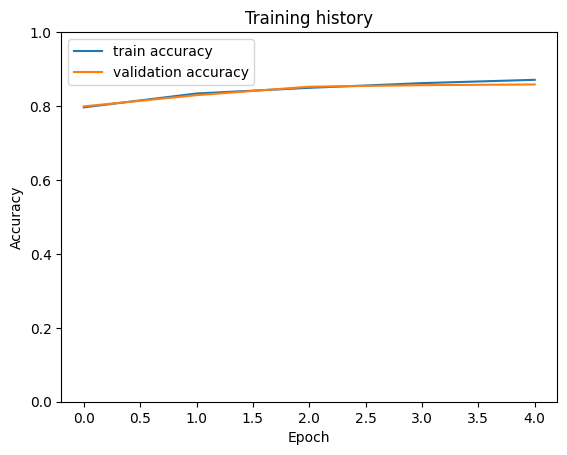

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Move tensors to CPU before converting to NumPy arrays
train_acc_cpu = [tensor.cpu().item() for tensor in history['train_acc']]
val_acc_cpu = [tensor.cpu().item() for tensor in history['val_acc']]

plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()


**NOTE:** The epochs are indexed from 0. Therefore in the following figure when x = 0.0 then it is epoch 1.

# (e) Result Analysis

Load the tokenizer and pretrained BERT model with some changes

In [61]:
# Load the pre-trained BERT model and tokenizer
model_final = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)

model_final = SentimentClassifier(3)
model_final = model.to(device)

Load the model with best validation accuracy 'best_model_state.bin' 

In [62]:
# Load the saved model state
model_final.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

'get_predictions' function generates predictions for a sentiment classification model on a specified data loader. It returns lists containing the review texts, predicted labels, prediction probabilities, and true labels for each example in the dataset. This function is useful for evaluating model performance, analyzing predictions, and understanding how well the model generalizes to new data.

In [ ]:
def get_predictions(model, data_loader):
      model = model.eval()
      review_texts = []
      predictions = []
      prediction_probs = []
      real_values = []
      with torch.no_grad():
            for d in data_loader:
                  texts = d["review_text"]
                  input_ids = d["input_ids"].to(device)
                  attention_mask = d["attention_mask"].to(device)
                  targets = d["targets"].to(device)
                  outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                  )
                  _, preds = torch.max(outputs, dim=1)
                  review_texts.extend(texts)
                  predictions.extend(preds)
                  prediction_probs.extend(outputs)
                  real_values.extend(targets)
      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return review_texts, predictions, prediction_probs, real_values

In [ ]:
test_acc, _ = eval_model(
  model_final,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model_final,
  test_data_loader
)

Following is the classification report which shows how well our model performed on the testing data. 

- Testing Accuracy: 82%

In [65]:
class_name = ['2', '0', '1']

print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

           2       0.71      0.81      0.76      3145
           0       0.49      0.13      0.21      1416
           1       0.87      0.93      0.90      9419

    accuracy                           0.82     13980
   macro avg       0.69      0.62      0.62     13980
weighted avg       0.80      0.82      0.80     13980



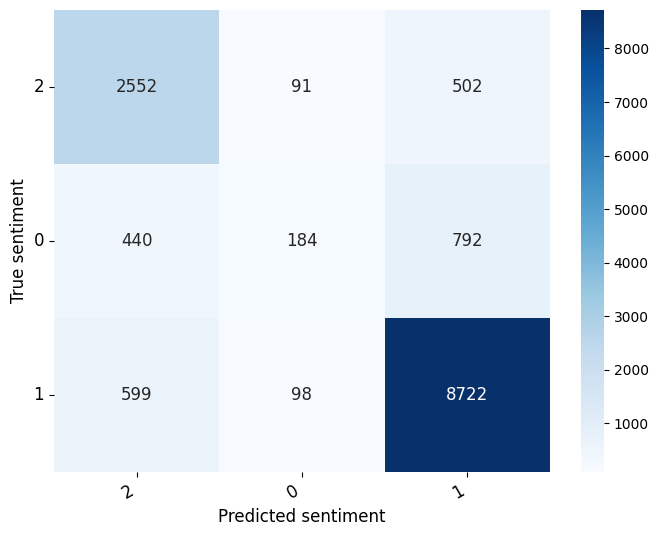

In [66]:
def show_confusion_matrix(confusion_matrix, class_names, figsize=(10, 7), fontsize=14, annot_kws={}):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    
    plt.figure(figsize=figsize)
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws=annot_kws)
    
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    
    plt.ylabel('True sentiment', fontsize=fontsize)
    plt.xlabel('Predicted sentiment', fontsize=fontsize)
    
    plt.show()

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_name, figsize=(8, 6), fontsize=12, annot_kws={"size": 12})

#### Following is the confusion matrix showcasing performance of our model on testing dataset. 

- We know that the following sentiments correspond to these labels 'Positive': 2, 'Negative': 0, 'Neutral': 1.
- We can see that our model performed well in predicting 'Neutral' and 'Positive' sentiments. 
- On the other hand our model failed to predict the 'Negative' sentiment correctly. 
- We had a descent validation accuracy while building the model and yet it is performing poorly for 'Negative' label. One of the reasons for this might be the imbalance in label distribution of the training data. I suspect that our training data had more 'Positive' and 'Neutral' labels than the 'Negative' labels.
- Hence, due to this we can observe that the f1-scores for 'Positive' and 'Neutral' are higher than that of 'Negative' sentiments.

### Hyper parameter Analysis:

1. Used Bert pretrained model as a part of transfer learning. The original BERT model, has 12 transformer layers but I freezed first 3 layers to reduce model complexity and save computational time. Moreover, Bert has 12 attention heads each layer. Hence, my model has 108 attention heads. 
2. Appended 2 linear layers and created a DNN to learn the classification.
3. Added dropout layers between them of 40% dropout rate to minimize overfitting of training data.
4. Used ReLU as the activation functions for linear activations which are not complex.
5. Finally, had an output layer with 3 output features which are the labels of the classification.